In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
import random

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset
import state_set

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)
importlib.reload(state_set)

from matrix_operation import mat_opr
from Dataset import dataset
from state_set import state_data

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows and columns
dset.drop_zero_rows()
dset.drop_zero_cols()

# drop all rows where Big10 isn't complete
dset = dset.drop_bad_rows()

In [4]:
# NOTE: this is just so I can visualize the input along with the
#       normalized outputs. Should not be used elsewhere

n = dset.dataframe.copy(deep=True)

for i in n.columns:
    n[i] /= n[i].max()

inp = mat_opr(n).dataframe

In [5]:
ranker = dset.rank_approx()
print(ranker)

1


In [6]:
ranker = 5

### Interpolate using Isotonic then Normalize

In [7]:
# doing isotonic first ensures that the last value is the greatest.
with_iso = dset.iso(unk=0)
normed = with_iso.normalizer()

In [8]:
X,Y = normed.sci_nmf(ranker, separate=True)
dotted = pd.DataFrame(np.dot(X,Y))
dotted.index = with_iso.dataframe.index
dotted.columns = with_iso.dataframe.columns
iso_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Boston University'}>

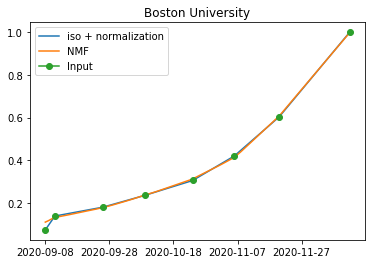

In [9]:
bu = pd.concat([inp['Boston University'], normed.dataframe['Boston University'], iso_nmf.dataframe['Boston University']], axis = 1)
bu.columns = ['Input','iso + normalization','NMF']

bu.drop('Input',1).plot(kind = 'line',legend=True, title = 'Boston University')

bu['Input'] = bu['Input'].replace(0,np.nan)
bu['Input'].plot(marker='o',legend=True)

### Look at the basis vectors

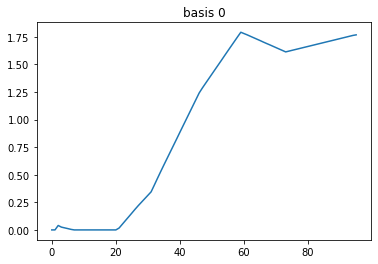

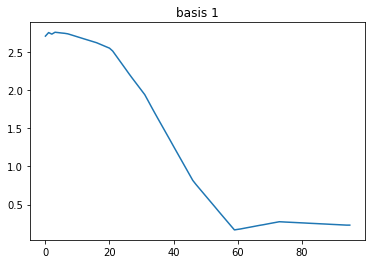

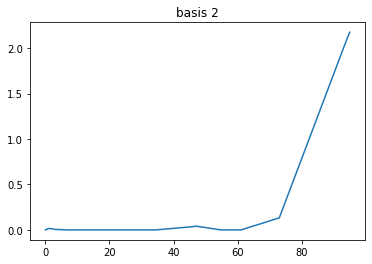

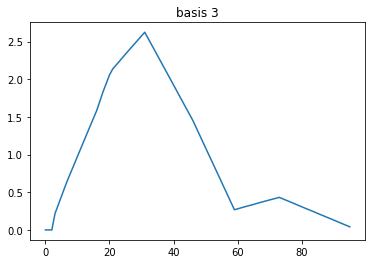

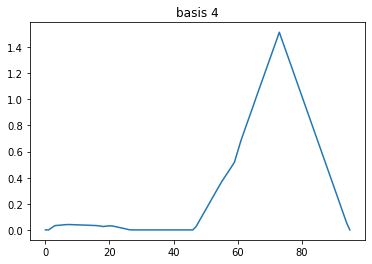

In [10]:
bases = pd.DataFrame(X)
    
for i in bases.columns:
    bases[i].plot()
    plt.title("basis " + str(i))
    plt.show()

## Clustering

In [11]:
def sort_by_cluster(labels):
    #helper function to see which columns are in which cluster
    cluster_dict = {lab:[] for lab in labels.value_counts().index}
    for i in range(len(labels)):
        cluster_dict[labels[i]].append(i) 
    return cluster_dict

In [12]:
def plot_cluster(data_obj, labels, mean = False, sample_size = 10):
    # plots a sample of data (or the mean of that sample) based on clustering results
    subs = labels.value_counts()
    fig, axs = plt.subplots(len(subs), figsize=(15,15))
    clust_dict = sort_by_cluster(labels)
    
    for i in clust_dict.keys():
        if sample_size > len(clust_dict[i]):
            for j in clust_dict[i]:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
        else:
            samples = random.sample(clust_dict[i], sample_size)
            for j in samples:
                data_obj.dataframe.iloc[:,j].plot(ax=axs[i])
            
    if mean:
        for k in clust_dict.keys():
            meaner = data_obj.dataframe.iloc[:,clust_dict[k]].mean(axis=1)
            meaner.plot(ax=axs[k], color='k', linewidth=4.0, label='center', legend=True)
            

### Cluster on original matrix (after isotonic)

In [13]:
kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(with_iso.array)))
county = pd.Series(kmeans.labels_)

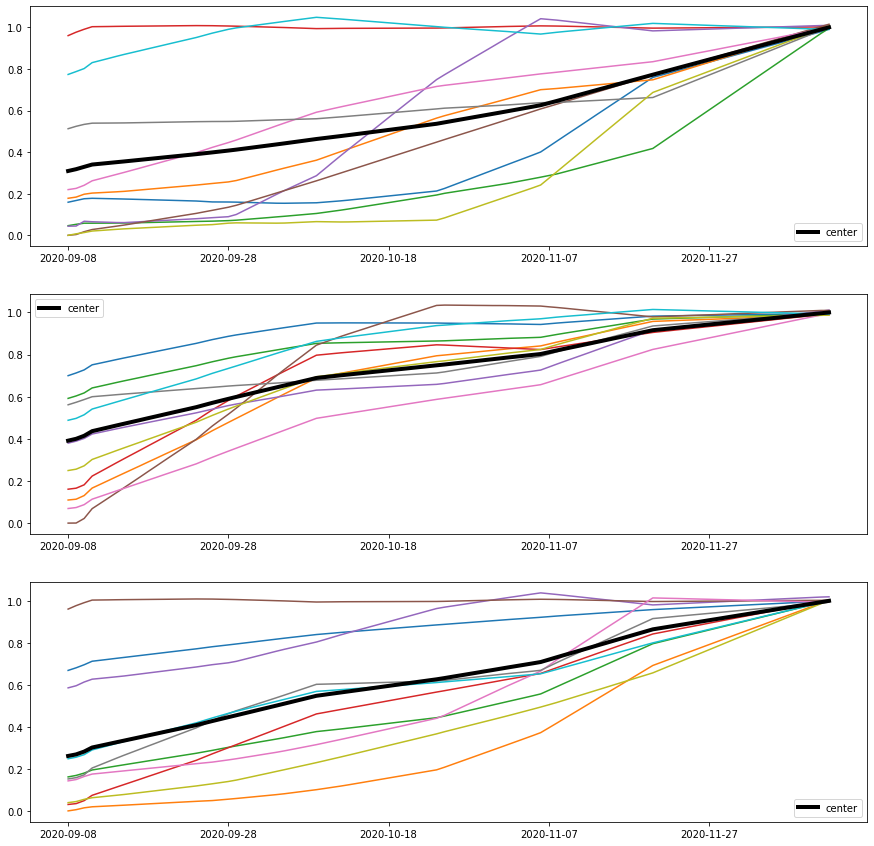

In [14]:
plot_cluster(iso_nmf, county,mean=True, sample_size=10)

### Cluster the vectors of Y after decomposition

In [15]:
yer = np.transpose(np.array(Y))

In [16]:
kmeans = KMeans(n_clusters=3, random_state=9).fit(yer)
counter = pd.Series(kmeans.labels_)

In [17]:
counter.value_counts()

0    760
1    720
2    392
dtype: int64

In [18]:
y_table = mat_opr(pd.DataFrame(yer).T)

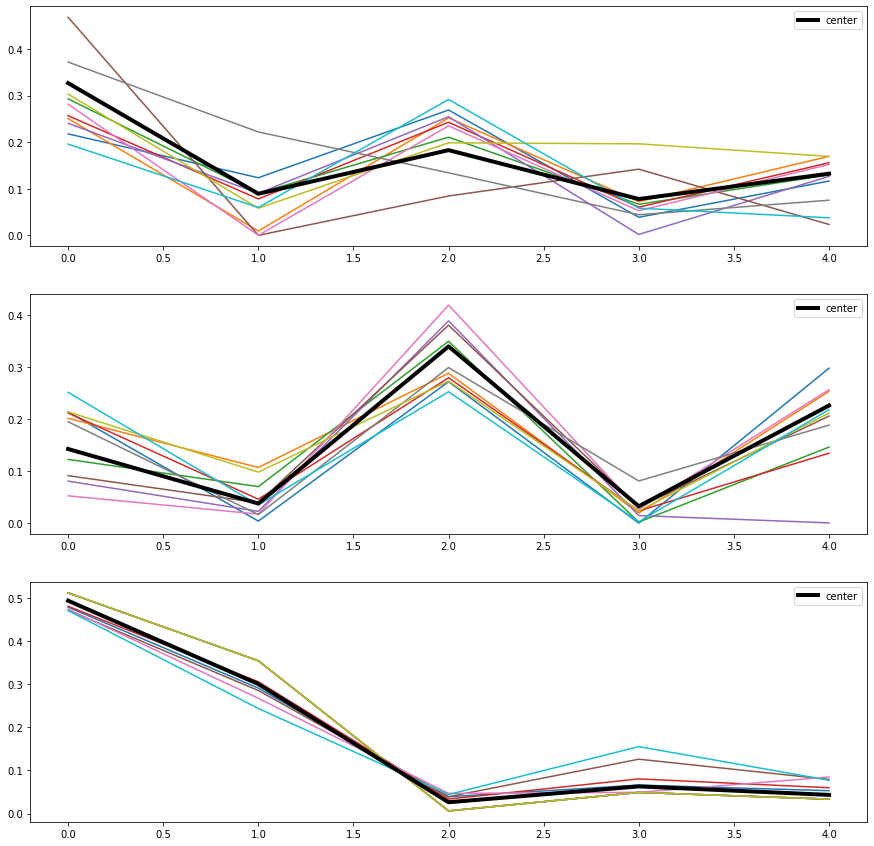

In [19]:
plot_cluster(y_table, counter, mean=True)

### Plot case curves based on their cluster of Y

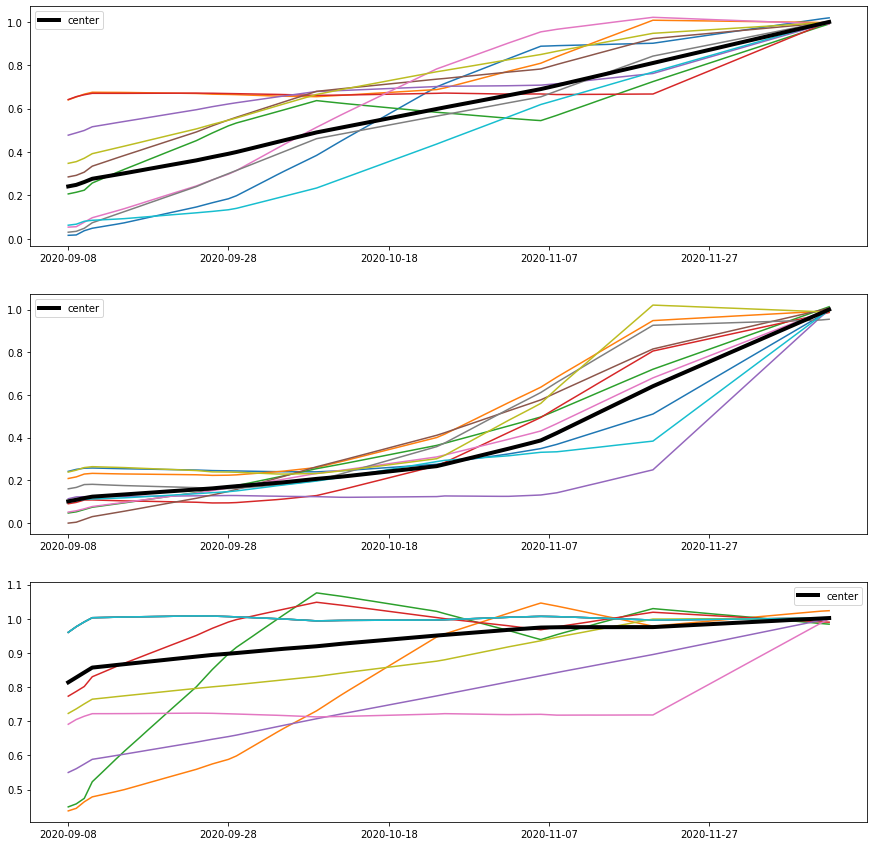

In [20]:
plot_cluster(iso_nmf, counter, mean=True)

# State Data

In [21]:
state_dset = state_data()

In [22]:
# ia0 and normalize:
state_iso = state_dset.known_iso()
state_norm = state_iso.normalizer()

In [23]:
state_norm.rank_approx(percent=0.95)

1

In [24]:
W,H = state_norm.sci_nmf(5, separate=True)
dotted = pd.DataFrame(np.dot(W,H))
dotted.index = state_norm.dataframe.index
dotted.columns = state_norm.dataframe.columns
state_nmf = mat_opr(dotted)

<AxesSubplot:title={'center':'Massachusetts Cases'}>

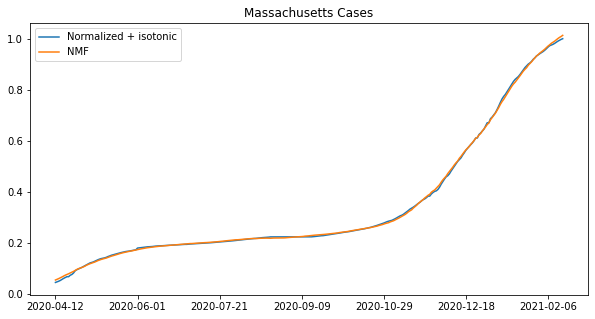

In [25]:
mass = pd.concat([state_norm.dataframe['Massachusetts'], state_nmf.dataframe['Massachusetts']], axis = 1)
mass.columns = ['Normalized + isotonic','NMF']

mass.plot(kind = 'line',legend=True, title = 'Massachusetts Cases', figsize=(10,5))


### Basis Vectors

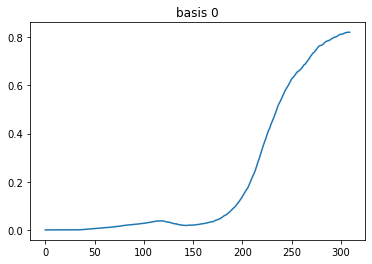

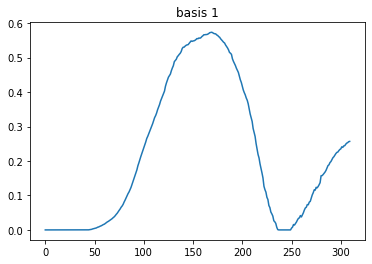

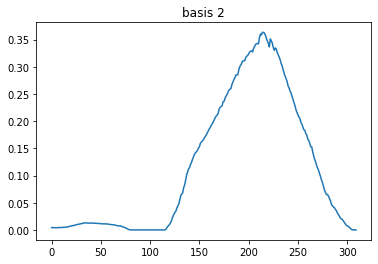

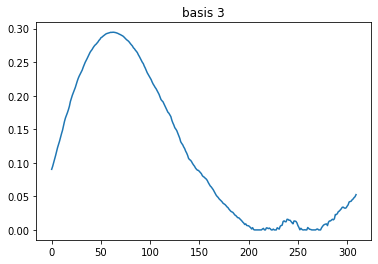

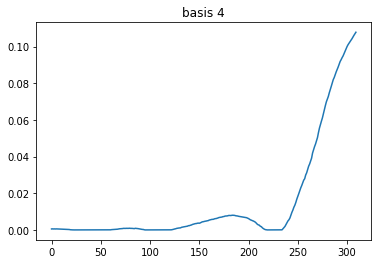

In [26]:
baser = pd.DataFrame(W)
    
for b in baser.columns:
    baser[b].plot()
    plt.title("basis " + str(b))
    plt.show()

### Cluster on raw input

In [27]:
kmeans = KMeans(n_clusters=3, random_state=9).fit(np.transpose(np.array(state_norm.array)))
counto = pd.Series(kmeans.labels_)

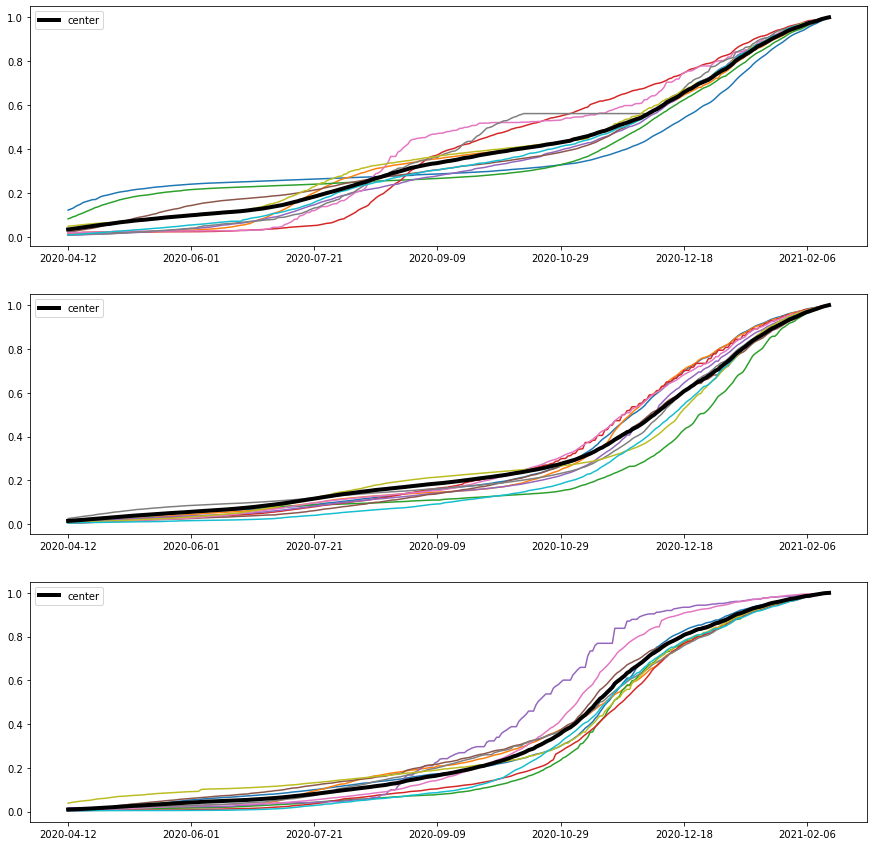

In [28]:
plot_cluster(state_norm, counto,mean=True)

### Cluster on Y after decomposition

In [29]:
h_t = np.transpose(H)

In [30]:
kmeans = KMeans(n_clusters=3, random_state=9).fit(h_t)
counti = pd.Series(kmeans.labels_)

In [31]:
h_table = mat_opr(pd.DataFrame(h_t).T)

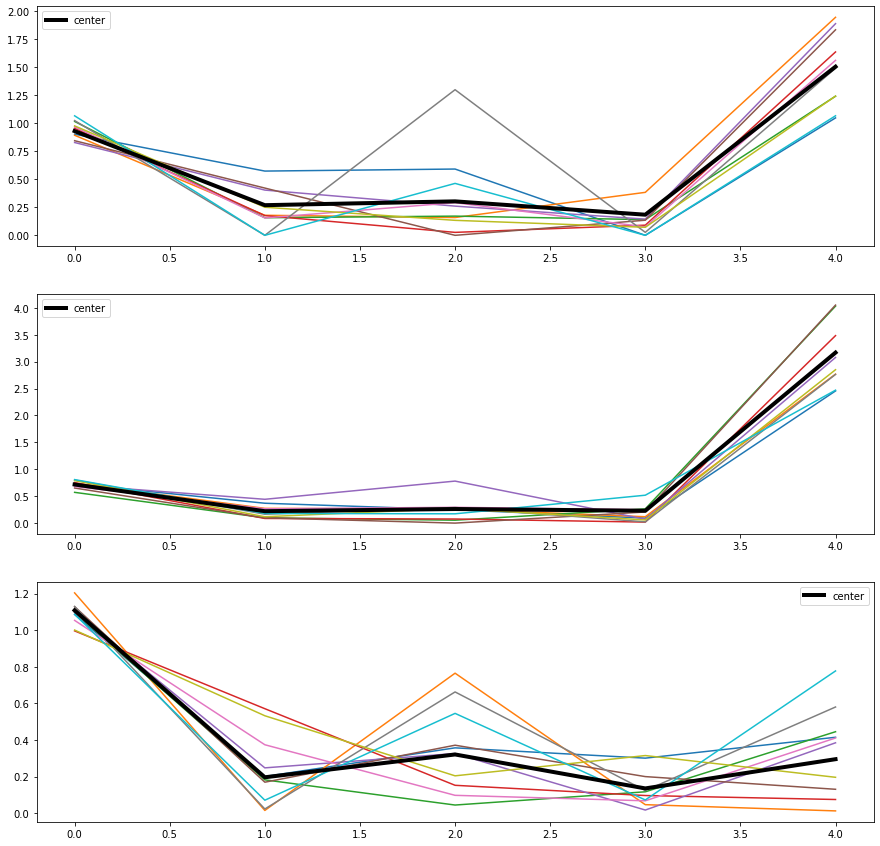

In [32]:
plot_cluster(h_table, counti, mean=True)

### Plot the case curves based on cluster of Y

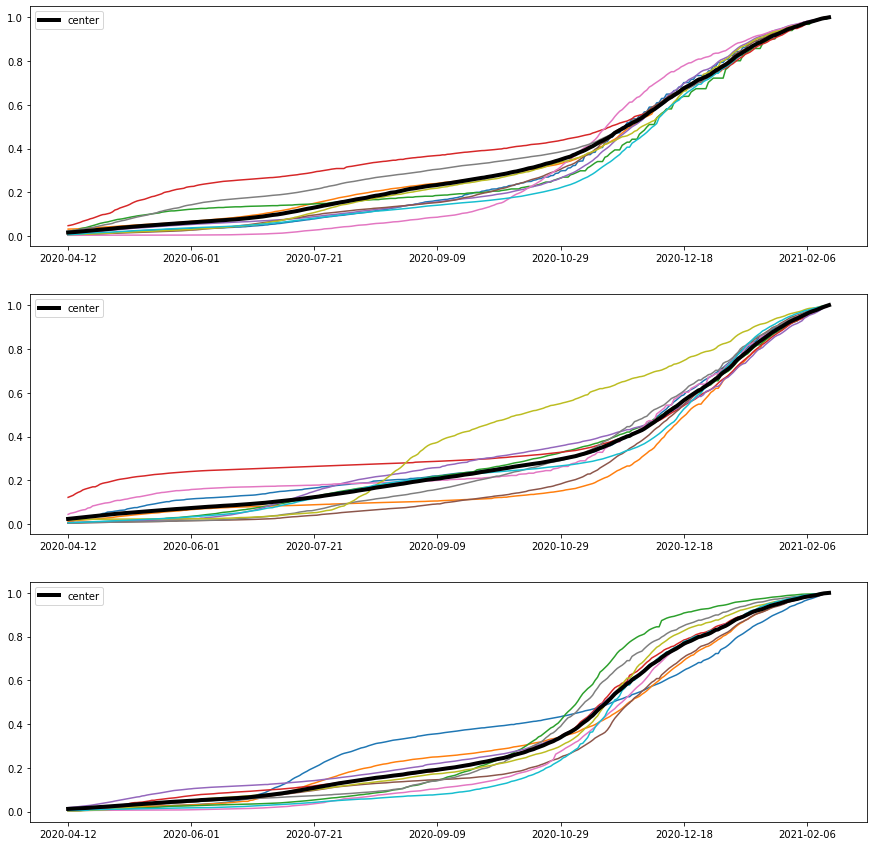

In [33]:
plot_cluster(state_norm, counti, mean=True)